In [ ]:
%load_ext autoreload
%autoreload 2


from src.chem_draw import make_svg_drawer_non_scaling, mol_to_svg
from rdkit import Chem
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFMCS, rdFingerprintGenerator, BRICS, Draw, Mol, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdChemReactions import ChemicalReaction
import rdkit.Chem.Draw.IPythonConsole
from IPython.display import SVG
from rdkit.Chem import Draw
import lxml
from src.config import filepaths
from src.utils import load_json
import ipywidgets as widgets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def draw_molecule(mol: str | Mol, size: tuple = (200, 200), use_svg: bool = True):
    '''
    Draw molecule.

    Args
    ----
    mol:str | Mol
        Molecule
    size:tuple
        (width, height)
    use_svg:bool
    '''
    if type(mol) is str:
        mol = Chem.MolFromSmiles(mol)

    if use_svg:
        drawer = Draw.MolDraw2DSVG(*size)
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        img = drawer.GetDrawingText()
    else:
        img = Draw.MolToImage(mol, size=size)

    return img

def draw_reaction(rxn: str | ChemicalReaction, sub_img_size: tuple = (200, 200), use_svg: bool = True, use_smiles: bool = True):
    '''
    Draw reaction.

    Args
    ----
    rxn:str | ChemicalReaction
    sub_img_size:tuple
        Substrate img size
    use_svg:bool
    use_smiles:bool
    '''
    if type(rxn) is str:
        rxn = Chem.rdChemReactions.ReactionFromSmarts(rxn, useSmiles=use_smiles)

    return Draw.ReactionToImage(rxn, useSVG=use_svg, subImgSize=sub_img_size)

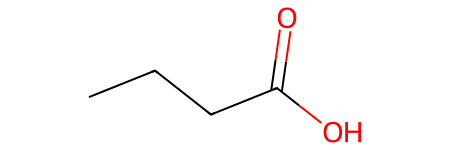

In [ ]:
smi = 'CCCC(=O)O'
mol = Chem.MolFromSmiles(smi)
mol.SetProp('label', "butanoic acid")
mol

In [4]:
fp = filepaths['imgs'] / "rxns" / "Rffe87c7bee7ad7ce62f14004e96690f1fd89cb69bac3b8baccd054256bcbd972.svg"
%timeit svg = widgets.Image.from_file(fp)

1.35 ms ± 59.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
sma = 'CCCC(=O)O>>CCCC=O.O'
txt = draw_reaction(sma)
btxt = txt.encode(encoding='UTF-8')

In [21]:
root = lxml.etree.fromstring(btxt)
root

<Element {http://www.w3.org/2000/svg}svg at 0x7feac23698c0>

In [23]:
for elt in root.iter():
    if elt.tag.endswith("text"):
        print(elt.tag)

AttributeError: '_cython_3_0_11.cython_function_or_method' object has no attribute 'endswith'

In [2]:
drawer = make_svg_drawer_non_scaling(width=300, height=200)

name_smi = {
    'methyl_dimethyl_ha': 'OC(C)C(C)(C)C(=O)O',
    'dipropyl_ha': 'OCC(CCC)(CCC)C(=O)O',
    'c4_methyl_diol': 'CC(O)C(C)(O)C',
    'hopa': 'O=C(O)C(=O)CCCO',
    'mvl_acid_precursor': 'C=C(CCCO)C(=O)O',
    'mvl': 'C=C1CCCOC1=O',
    '2_methylene_glutarate': 'C=C(CCC(=O)O)C(=O)O',
    '4_methylene_glutamate': 'C=C(CC(N)C(=O)O)C(=O)O',
    'xylose': 'O=CC(O)C(O)C(O)CO',
    'homocitrate': 'C(CC(CC(=O)O)(C(=O)O)O)C(=O)O',
    'hydroxypivalic_acid': 'OCC(C)(C)C(=O)O',

}

mols = [Chem.MolFromSmiles(smi) for smi in name_smi.values()]

for name, smi in name_smi.items():
    mol = Chem.MolFromSmiles(smi)
    txt = mol_to_svg(mol, drawer)

    with open(f"../artifacts/illustrative_imgs/{name}.svg", 'w') as f:
        f.write(txt)

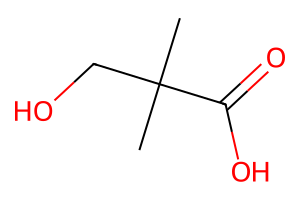

In [3]:
display(SVG(txt))